## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage import interpolation
import math
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, KFold

## Load Data

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/submission.csv')

## EDA

### 기본 데이터 확인

In [3]:
train

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2044,6,V,2,4,3,4,2,4,4,...,0,2,2,0,0,1,3,1,4,0
2044,2045,1,L,3,2,2,1,1,4,0,...,2,3,4,2,1,2,3,4,1,1
2045,2046,9,A,4,0,4,0,2,4,4,...,2,3,1,1,3,4,2,2,0,0
2046,2047,0,Z,2,3,3,0,3,0,4,...,2,3,1,1,0,4,1,4,3,1


In [4]:
test

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,...,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,...,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,...,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,...,2,0,0,4,3,3,3,4,4,2


In [5]:
pd.value_counts(train['letter'])

Z    91
K    90
O    90
L    89
H    89
G    87
Y    86
M    86
U    85
Q    82
T    82
R    81
F    80
X    79
N    77
S    76
D    76
C    74
V    73
A    72
B    71
W    69
J    67
P    66
E    66
I    64
Name: letter, dtype: int64

## 데이터 시각화

In [6]:
train.shape

(2048, 787)

In [7]:
X_temp = np.array(train[[str(i) for i in range(784)]][:32])
X_temp = X_temp.reshape(-1,1,28,28)
X_temp.shape

(32, 1, 28, 28)

In [8]:
train_digit = train['digit'].values
X_train_letter = train['letter'].values
X_test_letter = test['letter'].values

### 원본 데이터 시각화

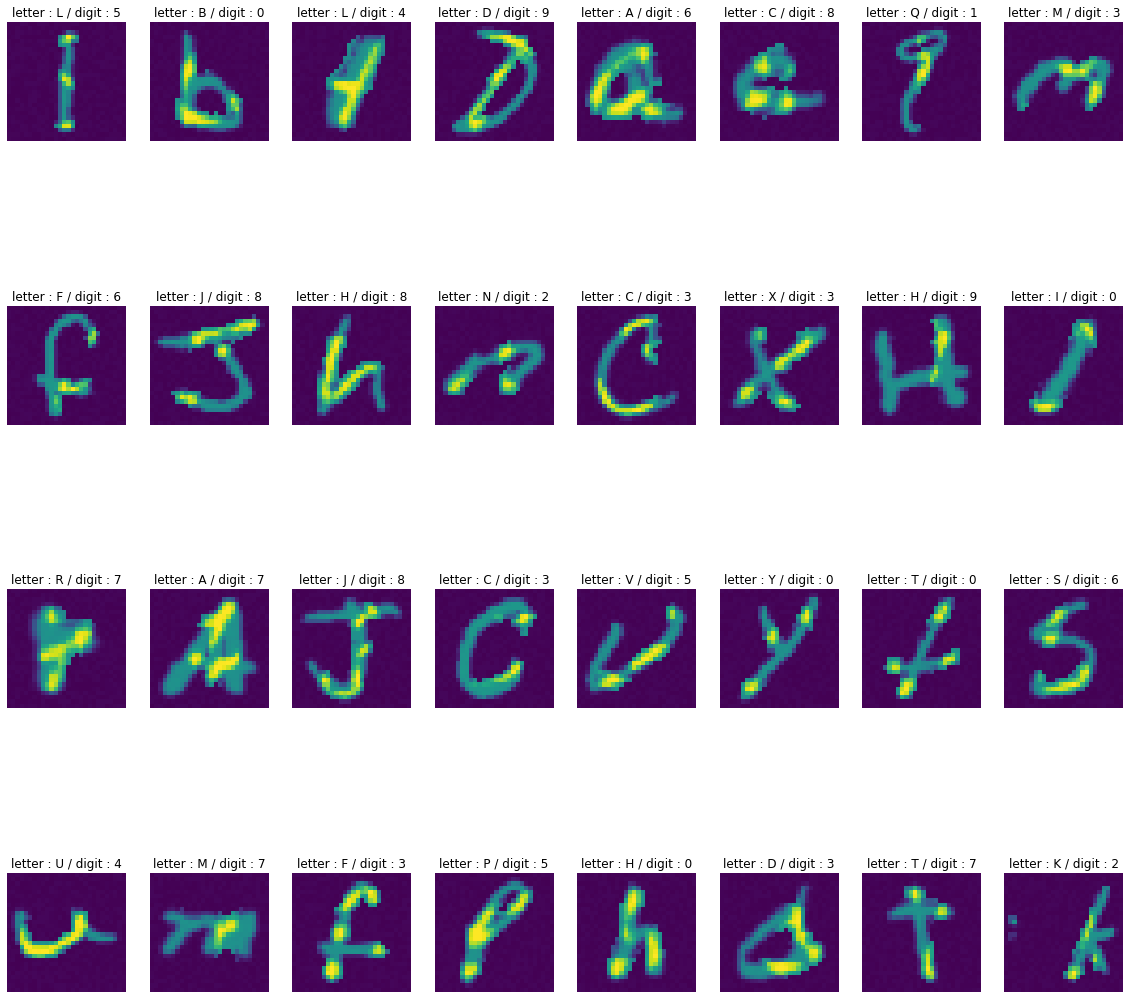

In [9]:
plt.figure(figsize=(20,20))
for idx, (image, digit, letter) in enumerate(zip(X_temp[:32], train_digit[:32] ,X_train_letter[:32])):
    plt.subplot(4,8,idx+1)
    plt.imshow(image[0])
    title = 'letter : {} / digit : {}'.format(letter, digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

우리 눈에는 알파벳 모양만 보이고 숫자는 가려져서 잘 보이지 않습니다.  
원본 데이터는 숫자 위에 알파벳 마스크가 덮여져 있는 상태입니다. 

## utility function

뒤에서 사용할 함수를 미리 만들어 줍니다.

### 모델 학습 graph 

In [10]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [11]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

### alphabet one-hot encoding (사용 안함)

In [12]:
def alpha_one_hot(x):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False)
    
    integer_encoded = label_encoder.fit_transform(x)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    
    x = onehot_encoder.fit_transform(integer_encoded)
    return x

### Deskew

이미지 형태를 일자로 맞춰줍니다.

In [13]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [14]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

In [15]:
def deskew_all(image_data):
    deskewed = []
    
    for i in range(len(image_data)):
        deskewed.append(deskew(image_data[i].reshape(28,28)))
    
    return np.array(deskewed)[:,:,:,np.newaxis]

## Feature Engineering

In [16]:
X_train = train.drop(['letter','id','digit'],axis=1)
TEST = test.drop(['letter','id'],axis=1)

X_trains = X_train.values.reshape(-1,28,28,1)
TEST = TEST.values.reshape(-1,28,28,1)

print(X_trains.shape)
print(TEST.shape)

(2048, 28, 28, 1)
(20480, 28, 28, 1)


In [17]:
y_trains = train['digit']
y_trains = utils.to_categorical(y_trains, 10)
y_trains.shape

(2048, 10)

### 데이터 늘리기

In [18]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.6,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [19]:
batch_size = 32
x_ = X_trains[:]
y_ = y_trains[:]
letter_ = alpha_one_hot(X_train_letter)
X_letter = alpha_one_hot(X_train_letter)
TEST_letter = alpha_one_hot(X_test_letter)

flow_image_digit = datagen.flow(x_, y_, batch_size=batch_size, seed=2020)
flow_image_letter = datagen.flow(x_, letter_, batch_size=batch_size, seed=2020)

In [20]:
for i in range(4):
#     gen_imgs =  np.array([0]*784*2048).reshape(2048,28,28,1)
    gen_imgs =  np.array([0]*784).reshape(1,28,28,1)
    gen_digits = np.array([0]*10).reshape(1,10)
    gen_letters = np.array([0]*26).reshape(1,26)
    
    for _ in range(len(x_)//batch_size):
        gen_img, gen_digit = flow_image_digit.next()
        gen_img, gen_letter = flow_image_letter.next()
        
        gen_imgs = np.vstack((gen_imgs,gen_img))
        gen_digits = np.vstack((gen_digits,gen_digit))
        gen_letters = np.vstack((gen_letters,gen_letter))
        
    X_trains = np.vstack((X_trains, gen_imgs[1:]))
    y_trains = np.vstack((y_trains, gen_digits[1:]))
    X_letter = np.vstack((X_letter, gen_letters[1:]))

In [21]:
print(X_trains.shape)
print(y_trains.shape)
print(X_letter.shape)

(10240, 28, 28, 1)
(10240, 10)
(10240, 26)


원본 데이터는 채널이 1개만 있습니다.  
우리는 이걸 3채널로 바꿀 것 입니다. 

### 숫자만 따로 분리하기

In [22]:
X_train_digit = digit_image(X_trains)
TEST_digit = digit_image(TEST)
X_train_digit.shape

(10240, 28, 28, 1)

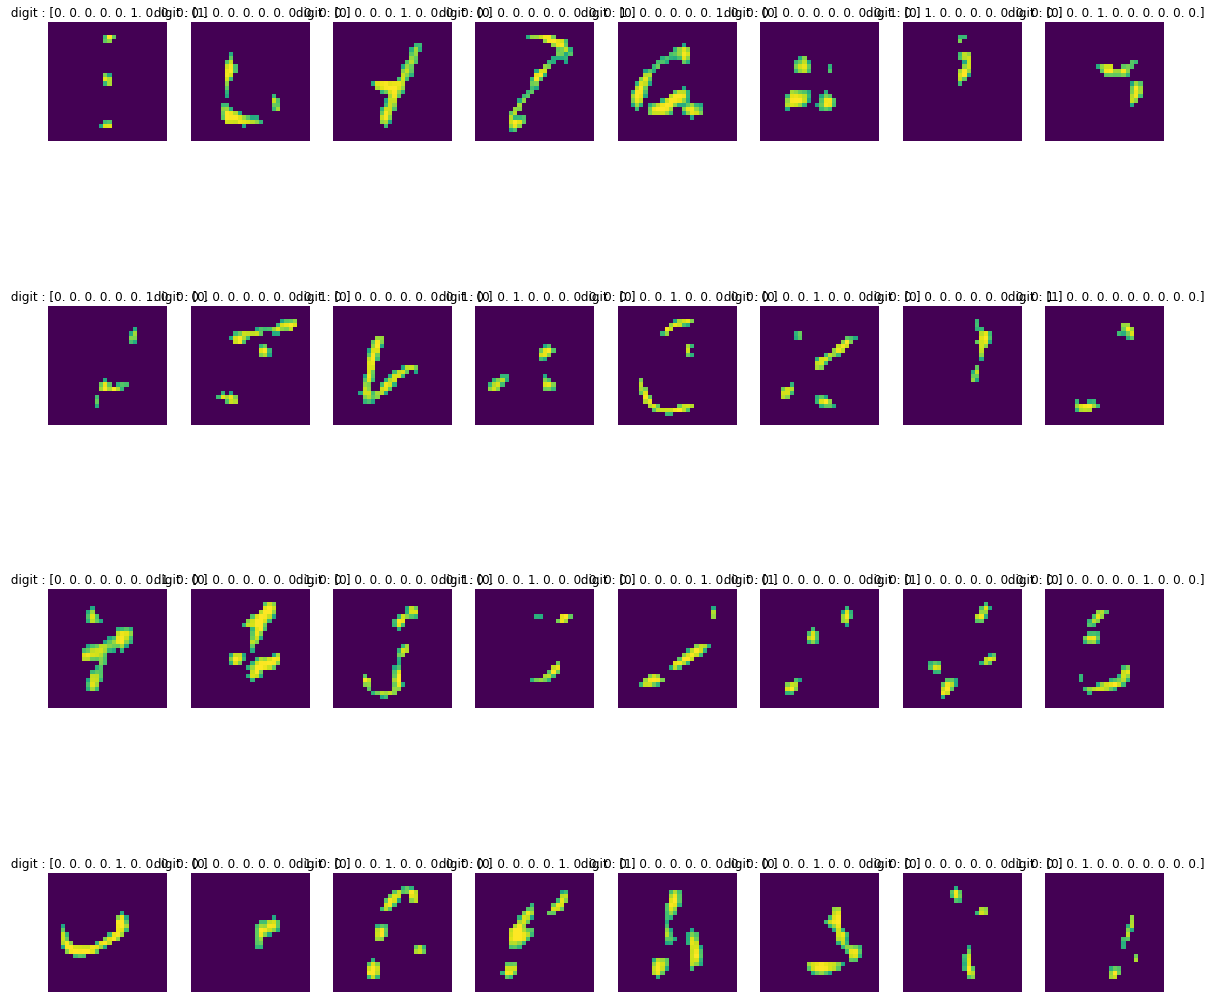

In [23]:
plt.figure(figsize=(20,20))
for idx, digit in enumerate(y_trains[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_train_digit[idx]))
    title = ' digit : {}'.format(digit)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

### 알파벳만 따로 분리하기

In [24]:
X_train_alpha = X_trains - X_train_digit/2
TEST_alpha = TEST - TEST_digit/2
X_train_alpha.shape

(10240, 28, 28, 1)

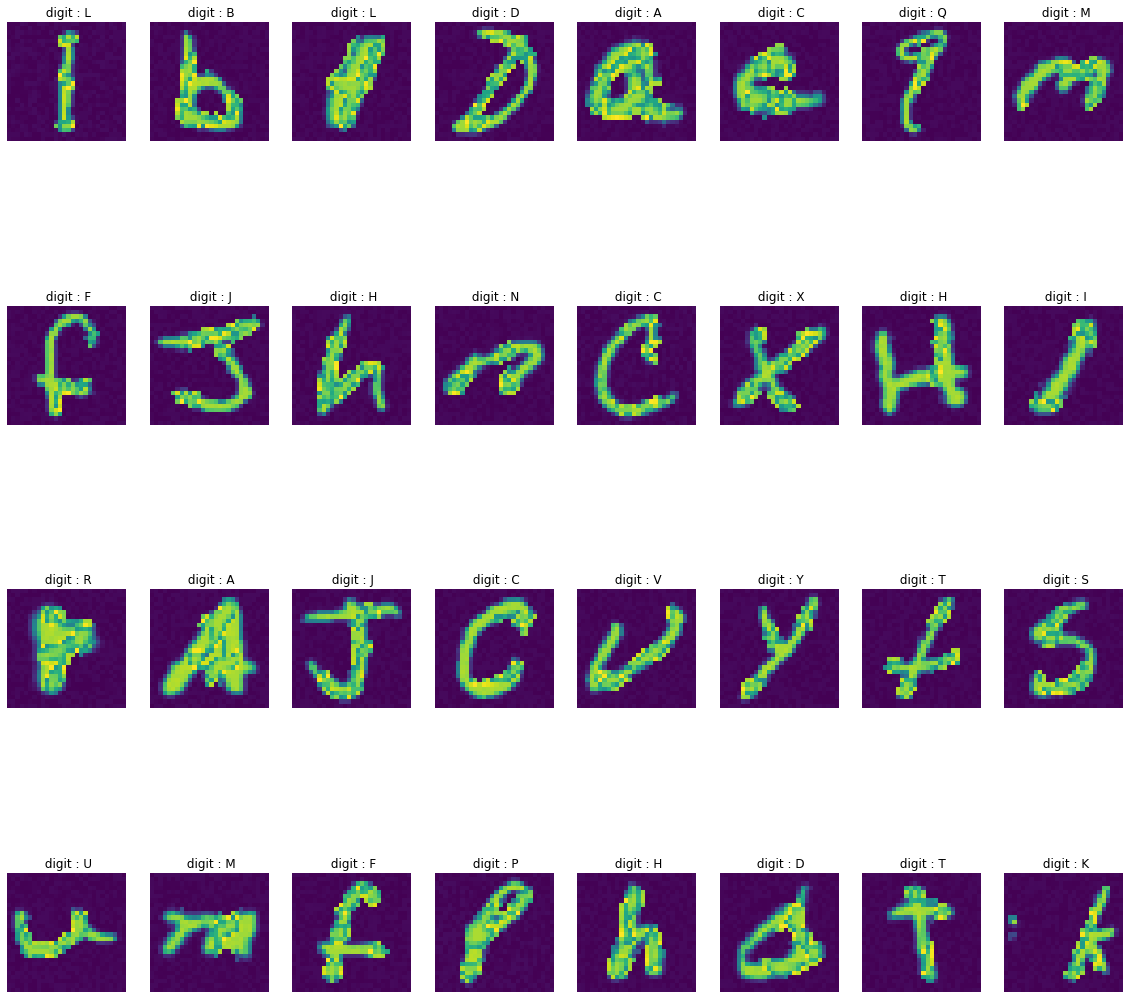

In [25]:
plt.figure(figsize=(20,20))
for idx, letter in enumerate(X_train_letter[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_train_alpha[idx]))
    title = ' digit : {}'.format(letter)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

### 분리한 알파벳 일자로 펴주기

In [26]:
X_train_alpha = deskew_all(X_train_alpha)
TEST_alpha = deskew_all(TEST_alpha)
X_train_alpha.shape

(10240, 28, 28, 1)

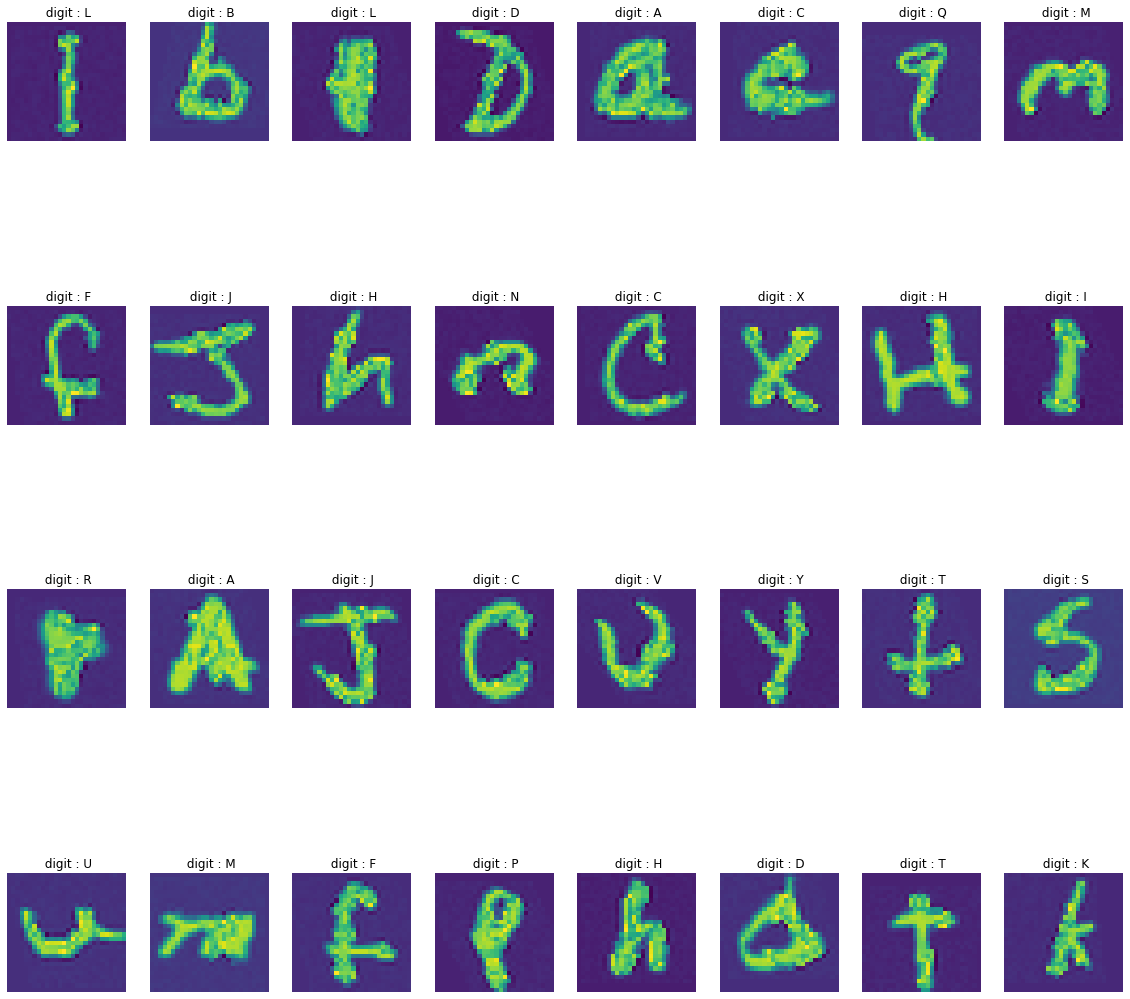

In [27]:
plt.figure(figsize=(20,20))
for idx, letter in enumerate(X_train_letter[:32]):
    plt.subplot(4,8,idx+1)
    plt.imshow(tf.squeeze(X_train_alpha[idx]))
    title = ' digit : {}'.format(letter)
    plt.title(title, fontdict={'color':'black'})
    plt.axis('off')

### 3채널 만들기 (원본, 숫자, 글자)

In [28]:
X_trains = np.concatenate((X_trains, X_train_digit, X_train_alpha),axis=-1)
TEST = np.concatenate((TEST, TEST_digit, TEST_alpha),axis=-1)

print(X_trains.shape)
print(TEST.shape)
print(y_trains.shape)
print(X_letter.shape)
print(TEST_letter.shape)

(10240, 28, 28, 3)
(20480, 28, 28, 3)
(10240, 10)
(10240, 26)
(20480, 26)


In [29]:
with open('../data/new_data.npy', 'wb') as f:
    np.save(f, X_trains)
    np.save(f, X_letter)
    np.save(f, y_trains)
    np.save(f, TEST)
    np.save(f, TEST_letter)